In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import spsolve
from scipy.sparse import identity, csgraph
import plotly

%matplotlib inline
data = pd.read_csv('./hochgerner_2018.data.gz',sep='\t',index_col=0)
anno = pd.read_csv('./hochgerner_2018.anno',sep='\t',header=None)
anno = anno[1].values


In [48]:
#We will first normalize each cell by total count per cell.
percell_sum = data.sum(axis=0)
pergene_sum = data.sum(axis=1)

preprocessed_data = data / percell_sum.values[None, :] * np.median(percell_sum)
preprocessed_data = preprocessed_data.values

#transform the preprocessed_data array by `x := log (1+x)`
preprocessed_data = np.log(1 + preprocessed_data)

#standard scaling
preprocessed_data_mean = preprocessed_data.mean(axis=1)
preprocessed_data_std = preprocessed_data.std(axis=1)
preprocessed_data = (preprocessed_data - preprocessed_data_mean[:, None]) / \
                     preprocessed_data_std[:, None]



In [49]:
#preprocess by PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
pca.fit(preprocessed_data.T)
pca_data = pca.transform(preprocessed_data.T)

Text(0, 0.5, 'PC2')

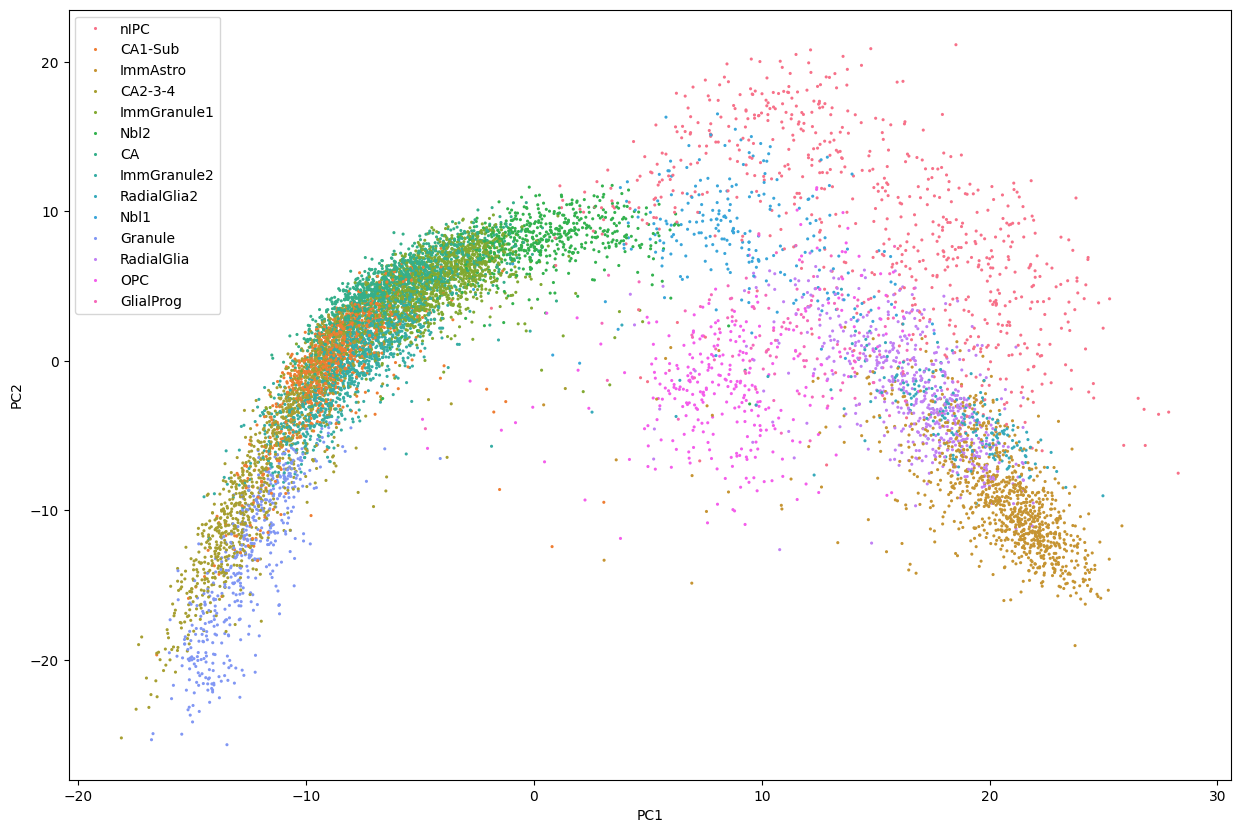

In [50]:
#visualize PCA result
plt.figure(figsize=(15,10))
seaborn.scatterplot(x=pca_data[:,0], y=pca_data[:,1], linewidth = 0, s=5, hue=anno)
plt.xlabel('PC1')
plt.ylabel('PC2')

##  GraphDR: nonlinear dimensionality reduction that preserves linear interpretability

GraphDR is a nonlinear dimensionality reduction method that preserves the linear interpretability while improving on cell type representation quality. GraphDR combines the advantages of linear methods such as PCA and nonlinear methods such as t-SNE. Unlike t-SNE, GraphDR is also suitable for comparison across datasets.

In [65]:
def graphdr(pca_data, anno, lambda_=20.0, no_rotation=False, num_neighbors=10, plot_graphdr=True):
    """
    Perform GraphDR dimensionality reduction using graph Laplacian smoothing.

    Parameters
    ----------
    pca_data : ndarray of shape (n_samples, n_features)
        Input data matrix in PCA-reduced space.
    anno : array-like of shape (n_samples,)
        Labels or annotations used for coloring the scatter plot.
    lambda_ : float, default=20.0
        Regularization strength for Laplacian smoothing.
    no_rotation : bool, default=False
        If True, skips eigenvector rotation.
    num_neighbors : int, default=10
        Number of neighbors to build the graph.
    plot_graphdr : bool, default=True
        If True, saves a scatter plot of the result.

    Returns
    -------
    Z : ndarray of shape (n_samples, n_features) or (n_samples, 2)
        The transformed low-dimensional embedding.

    Raises
    ------
    ValueError
        If `pca_data` has fewer rows than `num_neighbors`.

    See Also
    --------
    numpy.linalg.eigh : Computes eigenvalues and eigenvectors of a symmetric matrix.
    sklearn.neighbors.kneighbors_graph : Constructs the k-nearest neighbor graph.
    scipy.sparse.csgraph.laplacian : Computes the Laplacian matrix of a graph.


    Examples
    --------
    >>> Z = graphdr(pca_data, 10, True, 10)
    >>> Z.shape
    (10000, 2)

    """
    n, p = pca_data.shape

    # Construct identity matrix and k-NN graph
    I = np.identity(n)
    A = kneighbors_graph(pca_data, n_neighbors=num_neighbors, mode='connectivity').toarray()

    # Compute Laplacian and smoothing operator
    L = csgraph.laplacian(A, symmetrized=True)
    inverse_L = np.linalg.inv(I + lambda_ * L)

    # Compute projection matrix or skip rotation
    if not no_rotation:
        mul = pca_data.T @ inverse_L @ pca_data
        _, eigvec = np.linalg.eigh(mul)
        Z = inverse_L @ pca_data @ eigvec
    else:
        Z = inverse_L @ pca_data

    # Optional: generate plot
    if plot_graphdr:
        plt.figure(figsize=(15, 10))
        seaborn.scatterplot(x=Z[:, 0], y=Z[:, 1], linewidth=0, s=3, hue=anno)
        plt.xlabel('GraphDR 1')
        plt.ylabel('GraphDR 2')
        plt.title('GraphDR Projection')
        plt.tight_layout()
        plt.savefig(f'graphdr_result_{num_neighbors}nn_{lambda_}.png', dpi=300)
        plt.close()

    return Z

Text(0, 0.5, 'GraphDR 2')

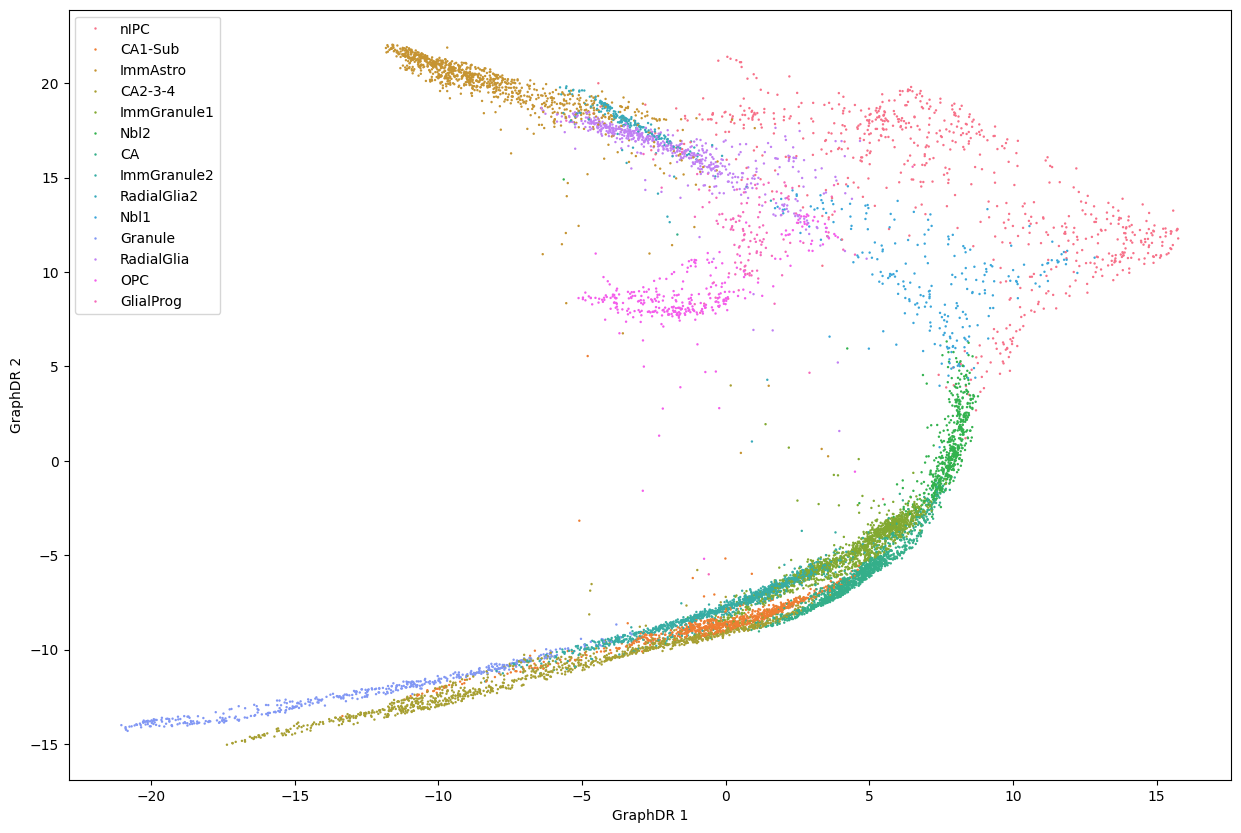

In [66]:

graphdr_result = graphdr(pca_data,10, True)
plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_result[:,0], y=graphdr_result[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')

Text(0, 0.5, 'GraphDR 2')

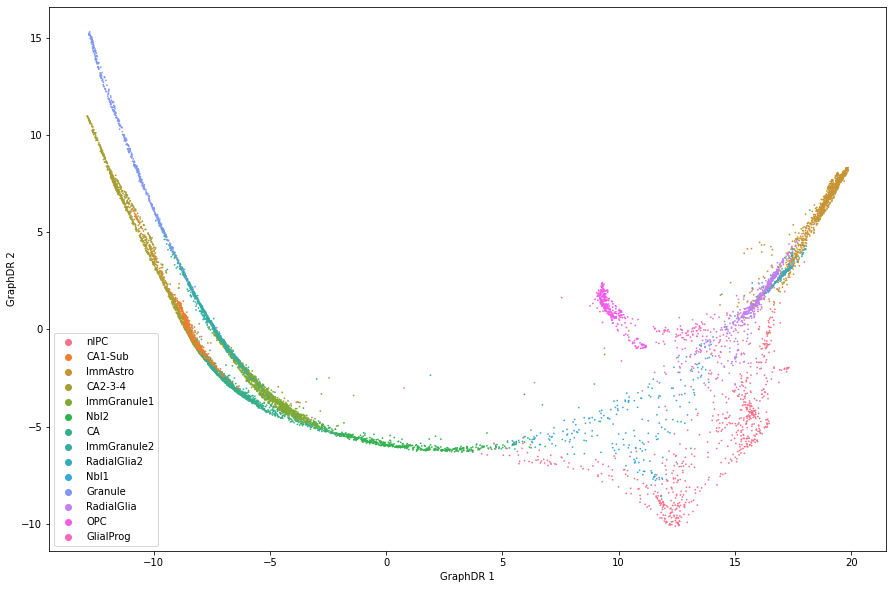

In [10]:
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')

# testing 3d plot for graphdr

In [67]:
lambda_values = np.logspace(-2, 2, 50) 
Z_list = []

for lam in lambda_values:
    Z = graphdr(pca_data, anno, lambda_=lam, no_rotation=False, num_neighbors=10, plot_graphdr=False)
    Z_list.append(Z[:, :3])  # Use only top 3 dimensions for 3D plotting


In [68]:
# import pickle

# with open("graphdr_3d_embeddings.pkl", "wb") as f:
#     pickle.dump(Z_list, f)


In [71]:
import pickle
with open("graphdr_3d_embeddings.pkl", "rb") as f:
    Z_list = pickle.load(f)

In [72]:
import plotly.graph_objects as go
import numpy as np

# Example:
# Z_list = [Z1, Z2, ..., Z50] where each Z.shape == (n_samples, 3)
# lambda_values = np.logspace(-2, 2, 50)

fig = go.Figure()

# Add one 3D scatter trace per lambda, only the first is visible
for i, Z in enumerate(Z_list):
    fig.add_trace(go.Scatter3d(
        x=Z[:, 0], y=Z[:, 1], z=Z[:, 2],
        mode='markers',
        marker=dict(size=3),
        name=f"λ={lambda_values[i]:.2f}",
        visible=(i == 0)
    ))

# Create slider steps
steps = []
for i in range(len(Z_list)):
    step = dict(
        method="update",
        args=[{"visible": [j == i for j in range(len(Z_list))]},
              {"title": f"GraphDR 3D Projection (λ = {lambda_values[i]:.2f})"}],
        label=f"{lambda_values[i]:.2f}"
    )
    steps.append(step)

# Add slider layout
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Lambda: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    scene=dict(
        xaxis_title="GraphDR 1",
        yaxis_title="GraphDR 2",
        zaxis_title="GraphDR 3"
    ),
    title="GraphDR 3D Projection Across Lambda Values"
)

fig.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

In [74]:
np.shape(Z_list)

(50, 10000, 2)